In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import mglearn
from sklearn.decomposition import PCA
from itertools import repeat, product
import time
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
%matplotlib inline


In [26]:
para = 0
for k in range(6, 12):
    n = 4**k * (500 - k + 1) + 4**k
    para += n
para

2747056128

In [3]:
def initialize_diag_matrix(k):
    k = 4**k
    v = [1] * k
    D = np.diag(v)
    return D
    

In [4]:
class kmer_featurization:

  def __init__(self, k):
    """
    seqs: a list of DNA sequences
    k: the "k" in k-mer
    """
    self.k = k
    self.letters = ['A', 'T', 'C', 'G']
    self.multiplyBy = 4 ** np.arange(k-1, -1, -1) # the multiplying number for each digit position in the k-number system
    self.n = 4**k # number of possible k-mers

  def obtain_kmer_feature_for_a_list_of_sequences(self, seqs, write_number_of_occurrences=False):
    """
    Given a list of m DNA sequences, return a 2-d array with shape (m, 4**k) for the 1-hot representation of the kmer features.

    Args:
      write_number_of_occurrences:
        a boolean. If False, then in the 1-hot representation, the percentage of the occurrence of a kmer will be recorded; otherwise the number of occurrences will be recorded. Default False.    
    """
    kmer_features = []
    for seq in seqs:
      this_kmer_feature = self.obtain_kmer_feature_for_one_sequence(seq.upper(), write_number_of_occurrences=write_number_of_occurrences)
      kmer_features.append(this_kmer_feature)

    kmer_features = np.array(kmer_features)

    return kmer_features

  def obtain_kmer_feature_for_one_sequence(self, seq, write_number_of_occurrences=False):
    """
    Given a DNA sequence, return the 1-hot representation of its kmer feature.

    Args:
      seq: 
        a string, a DNA sequence
      write_number_of_occurrences:
        a boolean. If False, then in the 1-hot representation, the percentage of the occurrence of a kmer will be recorded; otherwise the number of occurrences will be recorded. Default False.
    """
    number_of_kmers = len(seq) - self.k + 1

    kmer_feature = np.zeros(self.n)

    for i in range(number_of_kmers):
      this_kmer = seq[i:(i+self.k)]
      this_numbering = self.kmer_numbering_for_one_kmer(this_kmer)
      kmer_feature[this_numbering] += 1

    if not write_number_of_occurrences:
      kmer_feature = kmer_feature / number_of_kmers

    return kmer_feature

  def kmer_numbering_for_one_kmer(self, kmer):
    """
    Given a k-mer, return its numbering (the 0-based position in 1-hot representation)
    """
    digits = []
    for letter in kmer:
      digits.append(self.letters.index(letter))

    digits = np.array(digits)

    numbering = (digits * self.multiplyBy).sum()

    return numbering


In [49]:
nucleotides = np.loadtxt('../R_outputs/promoters.csv', dtype=str)
# random1 = "A" * 1000
# random2 = "A" * 996 + "GGGG"
# nucleotides = np.append(nucleotides, random1)
# nucleotides = np.append(nucleotides, random2)

In [50]:
def get_all_pos_kmers(k):
    letters = ['A', 'T', 'C', 'G']
    alphabet = []
    combinations = product(letters, repeat=k)
    for j in combinations:
        alphabet.append(''.join(j))
    return alphabet


In [51]:
def encode(nucleotides):

    encoded_nucleotides = []


    for nucleotide in nucleotides:

        encoded_nucleotide = []

        for k in range(1, 6):
            
            # create a list of possbile kmers
            alphabet = get_all_pos_kmers(k)
            
            # create a sparse matrix
            
            _sparse = initialize_diag_matrix(k)
    
            sparse = {}

            for i, kmer_1 in enumerate(alphabet):

                sparse[kmer_1] = {}

                for j, kmer_2 in enumerate(alphabet):

                    sparse[kmer_1][kmer_2] = _sparse[i, j]
            # kmer position
            
#             for number_of_kmers in range(len(nucleotide) - k + 1):
                
#                 nucleotide_kmer = nucleotide[number_of_kmers:(number_of_kmers+k)]
                
                
#                 for kmer in alphabet:
                    
#                     encoded_nucleotide.append(sparse[nucleotide_kmer][kmer])
             
            
            # kmer count
            obj = kmer_featurization(k) 
            
            kmer_feature = obj.obtain_kmer_feature_for_one_sequence(nucleotide, write_number_of_occurrences=True)
            
            encoded_nucleotide = list(kmer_feature) + encoded_nucleotide
            
            
        encoded_nucleotides.append(encoded_nucleotide)

    return np.array(encoded_nucleotides)

In [52]:
X = encode(nucleotides)

In [53]:
X.shape

(72, 1364)

In [54]:
# PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

In [55]:
# Label datapoints
label=[]
label.extend(repeat(0,72))

Text(0, 0.5, 'Second principal component')

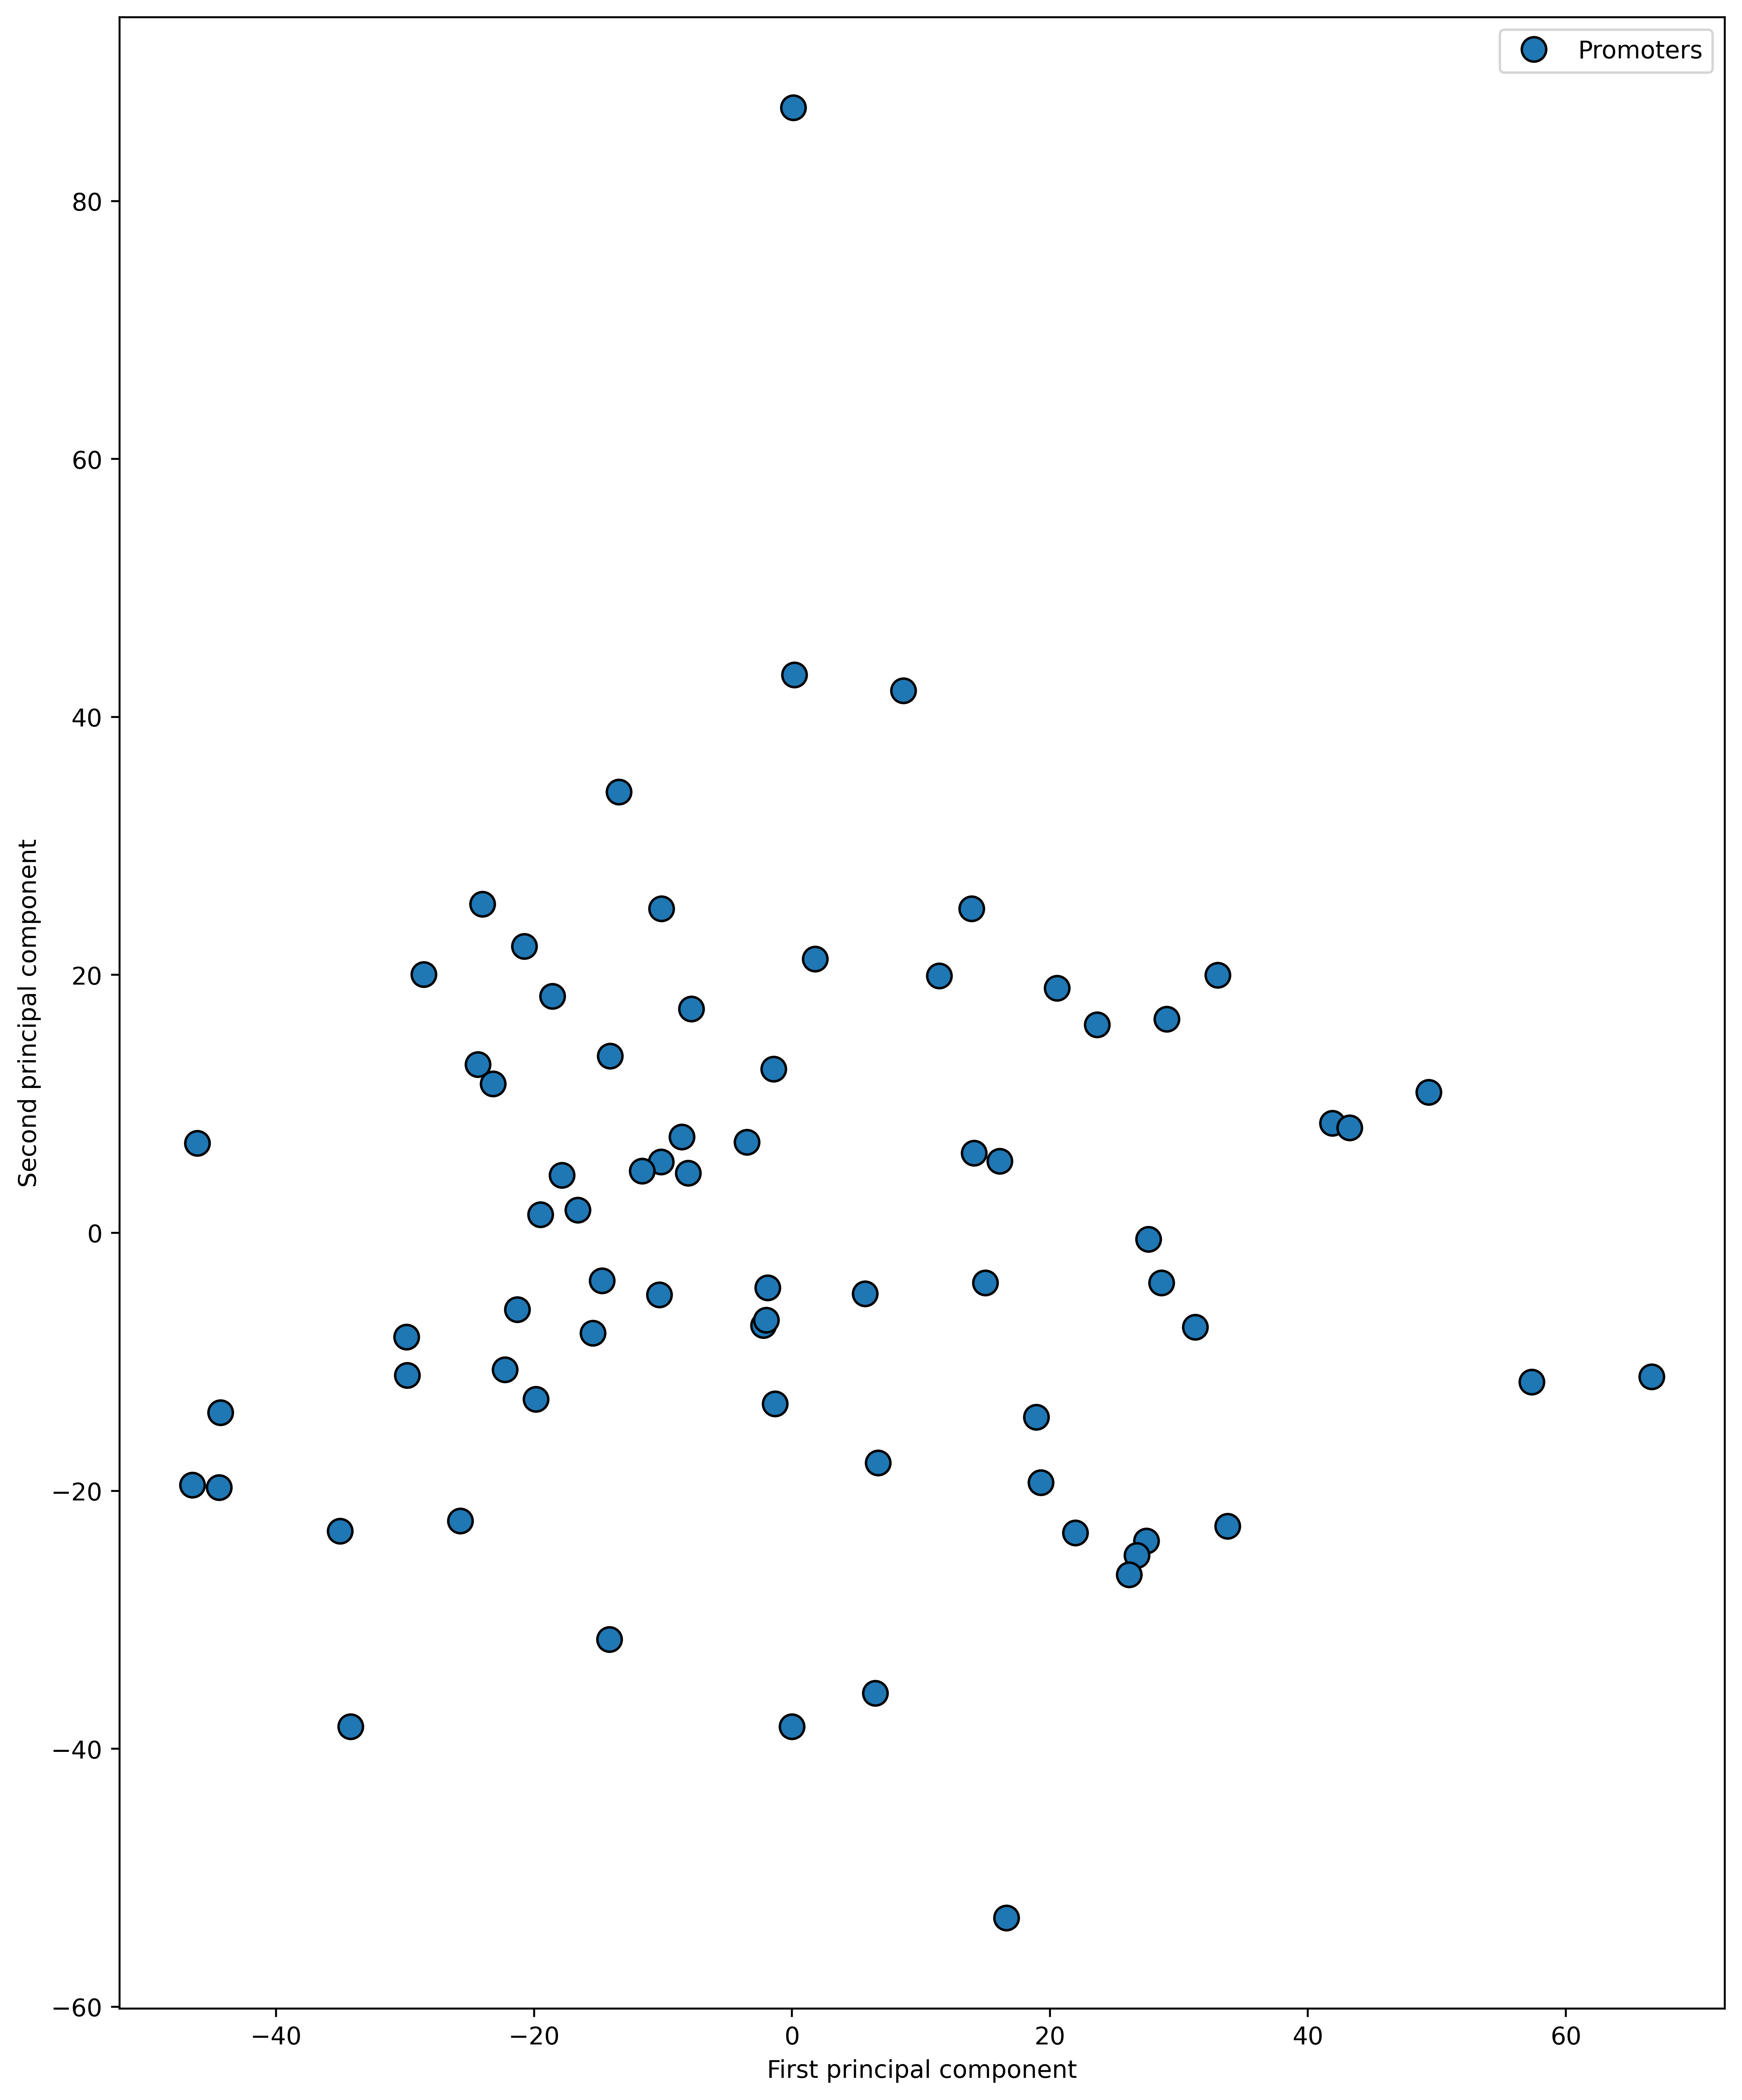

In [56]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(20, 15), dpi=500)
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], label)
plt.legend(["Promoters"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#plt.savefig('./PCA.jpg', bbox_inches='tight', dpi=600)

In [19]:
[N, p] = X_pca.shape

minX = list(np.min(X_pca, axis=0)) # data range min
maxX = list(np.max(X_pca, axis=0)) # data range max

In [20]:
clustersNr = 25
list_of_clusters = range(1,clustersNr + 1)
Nsim = 20
Wu = np.zeros((clustersNr, Nsim))
W = np.zeros(clustersNr)
for nrClusters in list_of_clusters: # Want actual number included
    kmeans = KMeans(n_clusters=nrClusters).fit(X_pca)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((X_pca[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku
        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

S:\anconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
S:\anconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
S:\anconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
S:\anconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

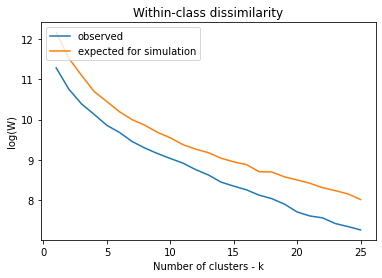

In [21]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

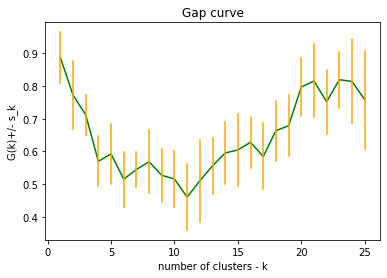

In [22]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

In [23]:
# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = clustersNr
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_of_clusters[K_opt[0]])

Gap-statistic, optimal K = 1


In [24]:
import random
col = []
for m in range(21):
    c = ["#"+''.join([random.choice('ABCDEF0123456789') for n in range(6)])]
    col.append(c)
    
def plotting(X, kmeans, y_pred, ax):
    ax.clear()
    for j in range(X.shape[0]):
        ax.scatter(X[j,0], X[j,1], c = col[y_pred[j]], marker= ".", s=80)
    for i in range(kmeans.cluster_centers_.shape[0]):
        ax.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], c = col[i], 
                   marker= "*", s=100, label=i)
    ax.legend()
    ax.set_title("Current iteration")
    

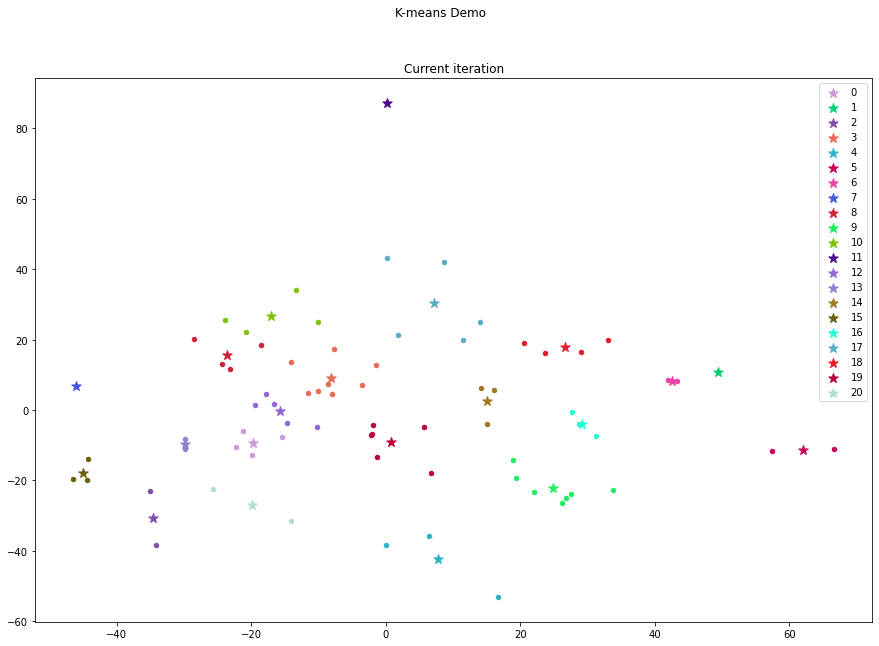

In [25]:
clusters = 21 # Control how many clusters we want

kmeans = KMeans(n_clusters = clusters, n_init = 1, random_state = 1, max_iter = 1)
y_pred = kmeans.fit_predict(X_pca)

fig, ax = plt.subplots(1,1, figsize=(15,10))
plt.suptitle("K-means Demo")
 
kmeans= KMeans(n_clusters = clusters, init = "random", random_state = 0)
y_pred = kmeans.fit_predict(X_pca)

plotting(X_pca, kmeans, y_pred, ax)

In [20]:
cluster_map = pd.DataFrame()
cluster_map['cluster'] = kmeans.labels_
cluster_map

,cluster
0,5
1,6
2,0
3,2
4,2
...,...
137,8
138,0
139,3
140,4


In [21]:
cluster_map.to_csv("./clusters.csv",index=False)

Text(0.5, 1.0, 'Automatic Clustering OPTICS')

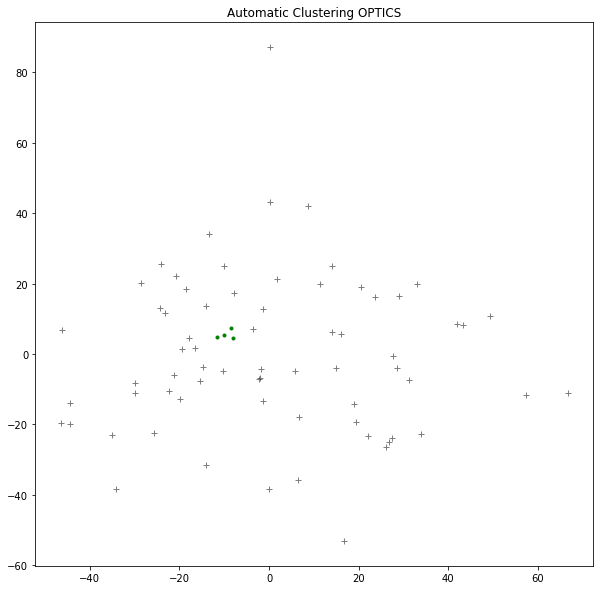

In [91]:
import matplotlib.gridspec as gridspec
clust = OPTICS(min_samples=4, min_cluster_size=0.05, max_eps=4)
# Run the fit
clust.fit(X_pca)
colors = ["g.", "r.", "b.", "y.", "c."]

plt.figure(figsize=(10, 10))
G = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(G[0, :])

for klass, color in zip(range(0, 5), colors):
    Xk = X_pca[clust.labels_ == klass]
    ax1.plot(Xk[:, 0], Xk[:, 1], color)
ax1.plot(X_pca[clust.labels_ == -1, 0], X_pca[clust.labels_ == -1, 1], "k+", alpha=0.5)
ax1.set_title("Automatic Clustering OPTICS")

In [78]:
cluster_map_OPTICS = pd.DataFrame()
cluster_map_OPTICS['cluster'] = clust.labels_
cluster_map_OPTICS

,cluster
0,-1
1,0
2,-1
3,-1
4,-1
...,...
67,-1
68,-1
69,-1
70,-1


In [79]:
cluster_map_OPTICS.to_csv("./clusters.csv",index=False)